2024-09-19 - Ronen Shekel

In [8]:
from lab.mplc.discrete_scan_result import DiscreetScanResult
%matplotlib ipympl
import glob, os, sys, datetime
import numpy as np
import matplotlib.pyplot as plt
from pianoq_results.scan_result import ScanResult
from pianoq_results.misc import my_mesh
from pianoq.misc.misc import detect_gaussian_spots_subpixel
from pianoq.misc.mplt import mimshow
from pianoq.simulations.mplc_sim.mplc_sim_result import MPLCSimResult
from matplotlib.patches import Rectangle

dir_path = r'G:\My Drive\Projects\MPLC\results\lab\2024_09_19_filters_80nm'


cant use py_thorlabs_ctrl.kinesis
could not import ThorlabsRotatingServoMotor


# Goals
I didn't have enough signal, so I wanted to check whether switching from 20nm filters to 80nm is possible without things going to bad. Ohad showed a while ago that it hurts the fidelity, but currently I don't really care that much about numbers, I just want quick results to better understand the system. 

So I begin by re-running with 20nm some discreet scan, and showing its restuls in single counts and coincidence. Then I  switch to the 80n filters and see the differences. I will then also look at the two-photon speckle with the new 80nm filters. 

# Single counts 
Here are the single counts I measured a few days ago: 

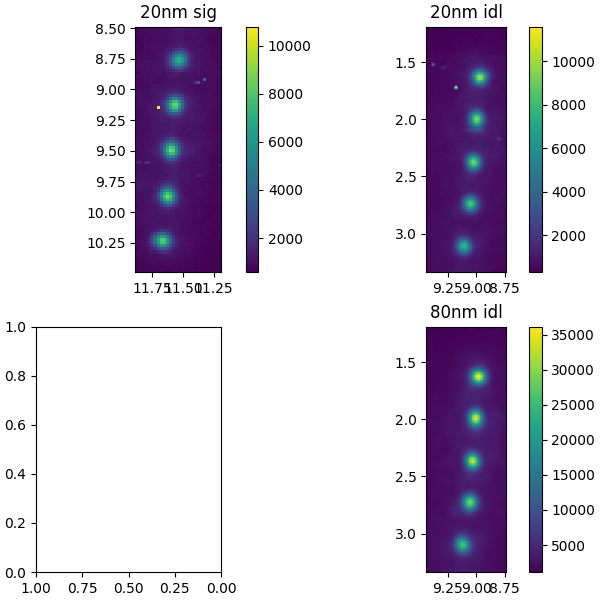

In [30]:
s20_sig_path = glob.glob(rf'{dir_path}\*signal*filter_20nm*.scan')[0]
s20_idl_path = glob.glob(rf'{dir_path}\*idler*filter_20nm*.scan')[0]
s20_sig = ScanResult(path=s20_sig_path)
s20_idl = ScanResult(path=s20_idl_path)


# s80_sig_path = glob.glob(rf'{dir_path}\*signal*filter_80nm*.scan')[0]
s80_idl_path = glob.glob(rf'{dir_path}\*idler*filter_80nm*.scan')[0]
# s80_sig = ScanResult(path=s80_sig_path)
s80_idl = ScanResult(path=s80_idl_path)

fig, axes = plt.subplots(2, 2, constrained_layout=True, figsize=(6, 6))
my_mesh(s20_sig.X, s20_sig.Y, s20_sig.single2s, axes[0, 0], title='20nm sig')
my_mesh(s20_idl.X, s20_idl.Y, s20_idl.single1s, axes[0, 1], title='20nm idl')

# my_mesh(s80_sig.X, s80_sig.Y, s80_sig.single2s, axes[1, 0], title='80nm sig')
my_mesh(s80_idl.X, s80_idl.Y, s80_idl.single1s, axes[1, 1], title='80nm idl')

axes[0, 0].invert_xaxis()
axes[0, 1].invert_xaxis()
axes[1, 0].invert_xaxis()
axes[1, 1].invert_xaxis()

It seems like the spot locations remain largly the same, with the same stoop shape at the bottom for instance. This is good, and indicates that the WFM works OK also for 80nm filters. A closer look shows that the spot location does change by ~10um, as evident by looking at the difference between the spot locations. It is actually kind of weird, it seems like all the spots together moved by some amount, and then there is some jitter. Maybe some backlash issue? (ALL the values of the difference are positive) 

In [49]:
locs_20_idl = detect_gaussian_spots_subpixel(s20_idl.single1s, s20_idl.X, s20_idl.Y)
locs_80_idl = detect_gaussian_spots_subpixel(s80_idl.single1s, s80_idl.X, s80_idl.Y)
# print(locs_20_idl)
# print(locs_80_idl)
print(f'Difference between idl locs (um):\n{(locs_80_idl - locs_20_idl) * 1e3}')

Difference between idl locs (um):
[[10.80215109 11.66978557]
 [ 5.5402126  11.74659554]
 [ 8.22800088 10.68206559]
 [ 9.19457169  7.63737141]
 [12.16059074  5.23953673]]


# Correlations

And here are the correaltions I meeasured now with integration times of 1s, 4s and 30s. 1s is pretty noisy, and 30s is probably enough.  

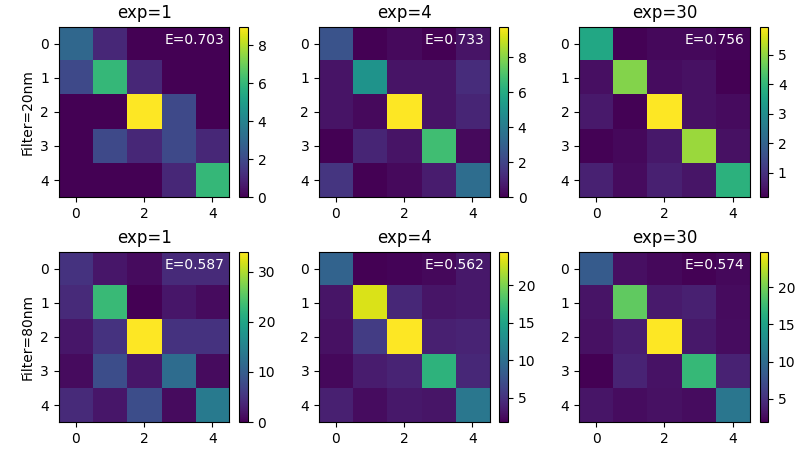

In [28]:
def get_scan(filter_type, exp_time):
    path = glob.glob(rf'{dir_path}\*filter_{filter_type}nm_exp_{exp_time}s.dscan')[0]
    d = DiscreetScanResult()
    d.loadfrom(path)
    return d

def show_coin(s, ax):
    imm = ax.imshow(s.coincidences)
    ax.figure.colorbar(imm, ax=ax)
    ax.set_title(f'exp={s.integration_time}')
    ax.text(2.6, 0, f'E={np.diag(s.coincidences).sum() / s.coincidences.sum():.3f}', color='white')

fig, axes = plt.subplots(2, 3, constrained_layout=True, figsize=(8, 4.5))
for j, filt in enumerate([20, 80]):
    for i, exp_time in enumerate([1, 4, 30]):
        show_coin(get_scan(filt, exp_time), axes[j, i])

axes[0, 0].set_ylabel('Filter=20nm')
_ = axes[1, 0].set_ylabel('Filter=80nm')

# Speckles

Finally, we meaure a two-photon speckle with the 80nm filters. and compare to the speckle we measured with 20nm filters which needed an integration time of 60s. 

In [2]:
speckles_20_path = glob.glob(rf'{dir_path}\*two_ph_speckle*d1d*filter_20nm*.scan')[0]
speckles_20 = ScanResult(path=speckles_20_path)

speckles_80_path = glob.glob(rf'{dir_path}\*two_ph_speckle*d1d*filter_80nm*.scan')[0]
speckles_80 = ScanResult(path=speckles_80_path)

def show(s, ax, title):
    imm = ax.imshow(s.coincidences)
    ax.figure.colorbar(imm, ax=ax)
    ax.set_title(

fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(6, 3))

show(speckles_20, axes[0], title=f'exp={speckles_20.integration_time}, filter=20nm')
show(speckles_80, axes[1], title=f'exp={speckles_80.integration_time}, filter=80nm')